# Testing body-to-field operators in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Testing body-to-field operations

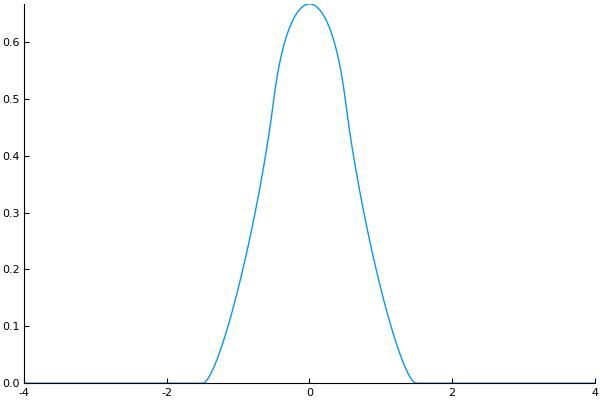

In [3]:
ddf = DDF();
x = linspace(-4,4,401);
plot(x,ddf.(x),legend=false)

In [3]:
x = [0.25,0.75,0.25]; y = [0.75,0.25,0.25];
X = VectorData(x,y);
q = Edges(Primal,(12,12));
dx = 0.1;
H = Regularize(x,y,dx)

Regularization/interpolation operator with non-filtered interpolation
  3 points in grid with cell area 0.01


#### Set up a circle of points

In [4]:
n = 100;
θ = linspace(0,2π,n+1);
x = 0.5 + 0.25*cos.(θ[1:n])
y = 0.5 + 0.25*sin.(θ[1:n])
ds = 2π/n*0.25;
X = VectorData(x,y);
f = ScalarData(X);

#### Set up the physical dimensions of the grid and create empty data

In [5]:
nx = 102; ny = 102;
Lx = 1.0;
dx = Lx/(nx-2);
q = Edges(Primal,(nx,ny));
w = Nodes(Dual,(nx,ny));
w̃ = Nodes(Primal,w);
p = Edges(Dual,w);

#### Create a regularization operator with the point data

In [6]:
H = Regularize(X,dx;weights=ds)

Regularization/interpolation operator with non-filtered interpolation
  100 points in grid with cell area 0.0001


In [7]:
H̃ = Regularize(X,dx;weights=ds,filter=true)

Regularization/interpolation operator with filtered interpolation
  100 points in grid with cell area 0.0001


#### Now set up some data on the points and regularize it to primal edge data on the grid 

In [15]:
f = VectorData(X)
fill!(f.u,1.0);
f.v .= X.v.-0.5;
@time H(q,f);

  0.060908 seconds (144.23 k allocations: 54.704 MiB, 20.02% gc time)


We can also create a matrix representation of the regularization, and apply it:

In [13]:
Hmat = RegularizationMatrix(H,f,q);

Notice that it is a lot faster:

In [16]:
@time q = Hmat*f;

  0.000050 seconds (13 allocations: 203.375 KiB)


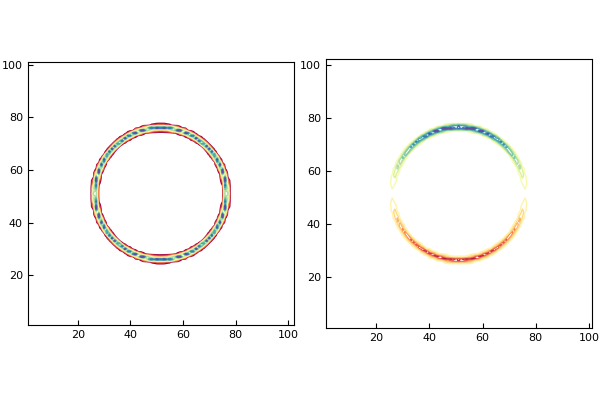

In [17]:
plot(q)

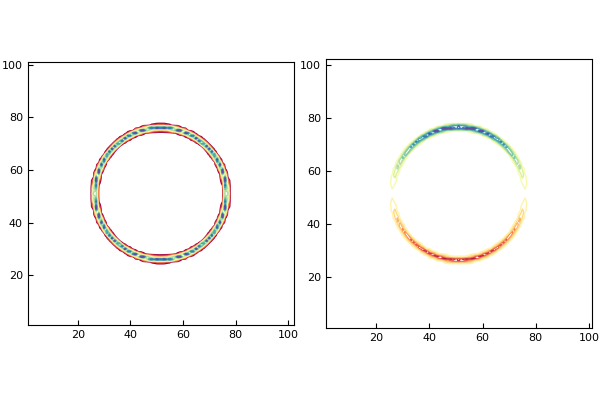

In [18]:
q2 = Edges(Primal,(nx,ny));
H(q2,f)
plot(q2)

In [19]:
@time H(q,f);

  0.061043 seconds (144.24 k allocations: 54.705 MiB, 9.90% gc time)


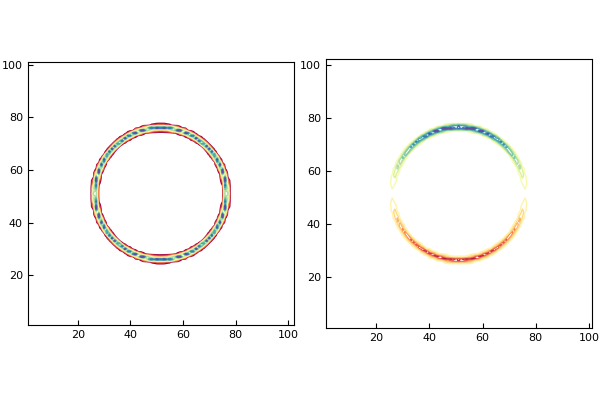

In [20]:
H(q,f);
plot(q)

  0.148526 seconds (204.27 k allocations: 57.200 MiB, 7.80% gc time)


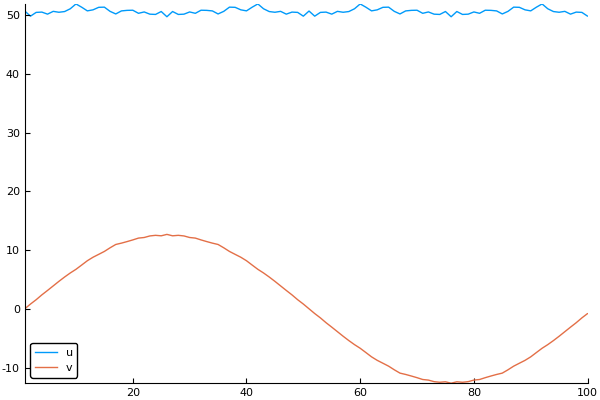

In [21]:
f2 = VectorData(X);
@time H(f2,q);
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

In [22]:
Emat = InterpolationMatrix(H,q,f2);

  0.063078 seconds (43.26 k allocations: 2.056 MiB, 8.76% gc time)


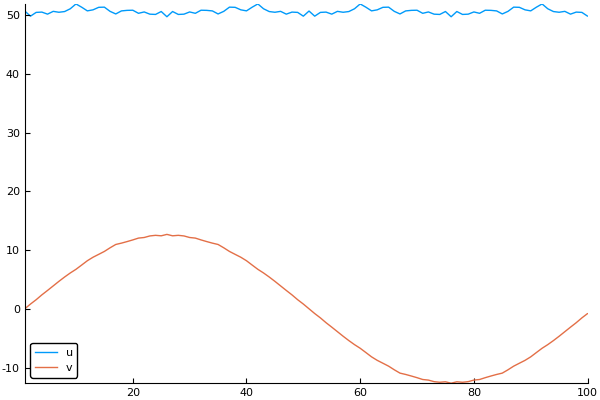

In [23]:
@time f2 = Emat*q
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

#### Vector data onto dual edge field

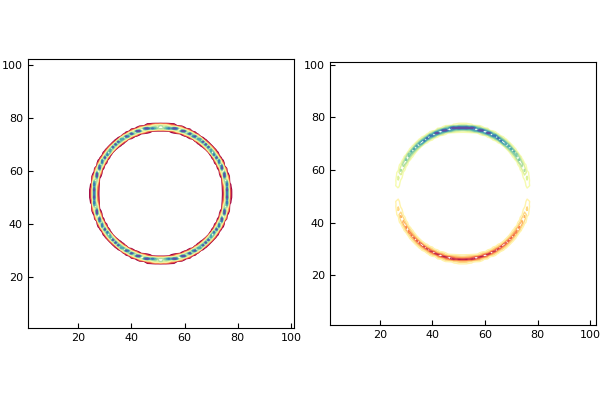

In [24]:
H(p,f);
plot(p)

#### Vector data onto primal and dual nodal data

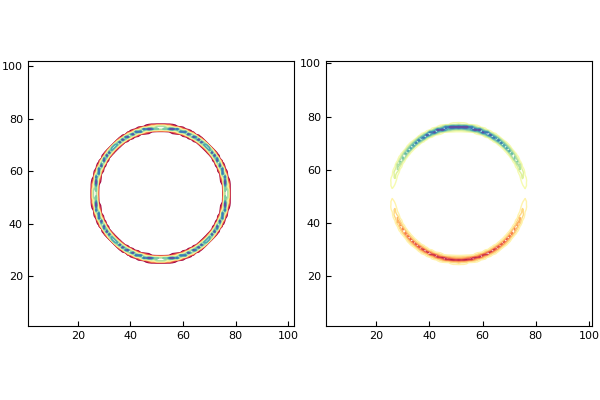

In [27]:
wpair = NodePair(Dual,Primal,(nx,ny))
H(wpair,f);
plot(wpair)

In [28]:
Hmat = RegularizationMatrix(H,f,wpair);

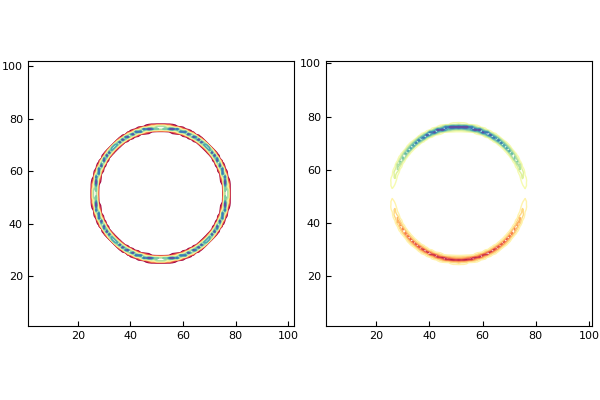

In [29]:
plot(Hmat*f)

In [32]:
wpair.u .= rand(size(wpair.u));
wpair.v .= rand(size(wpair.v));

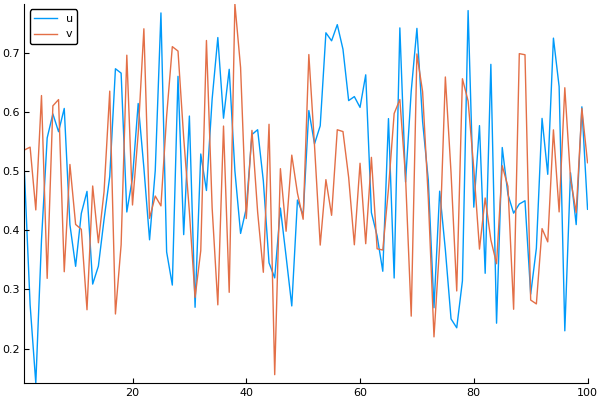

In [33]:
f2 = VectorData(X);
H(f2,wpair);
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

#### Scalar data onto dual nodal field

  0.076031 seconds (83.02 k allocations: 28.039 MiB, 6.86% gc time)


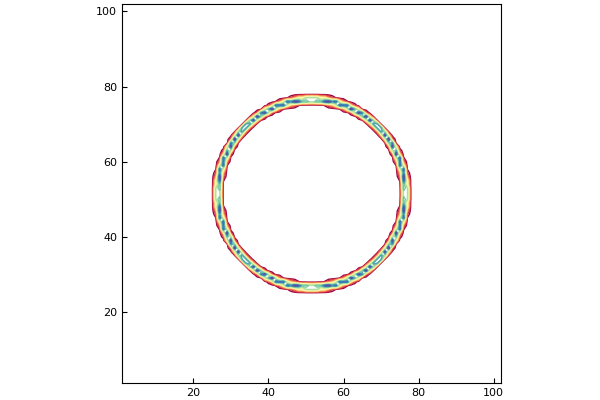

In [34]:
g = ScalarData(X)
fill!(g,1.0)
@time H(w,g)
plot(w)

#### Set up a matrix form of regularization

In [35]:
g = ScalarData(X)
w = Nodes(Dual,(nx,ny));
@time Hmat = RegularizationMatrix(H,g,w);
@time Emat = InterpolationMatrix(H,w,g);

  2.737672 seconds (7.29 M allocations: 2.700 GiB, 9.45% gc time)
  2.702891 seconds (7.29 M allocations: 2.700 GiB, 9.16% gc time)


  0.014374 seconds (4.85 k allocations: 269.996 KiB)


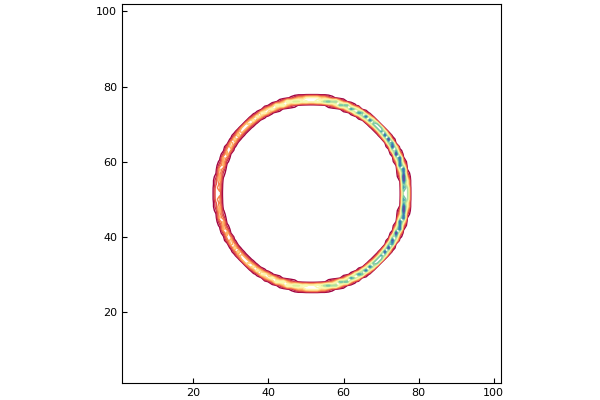

In [36]:
g = ScalarData(X)
g .= sin.(X.u)
@time A_mul_B!(w,Hmat,g)
plot(w)

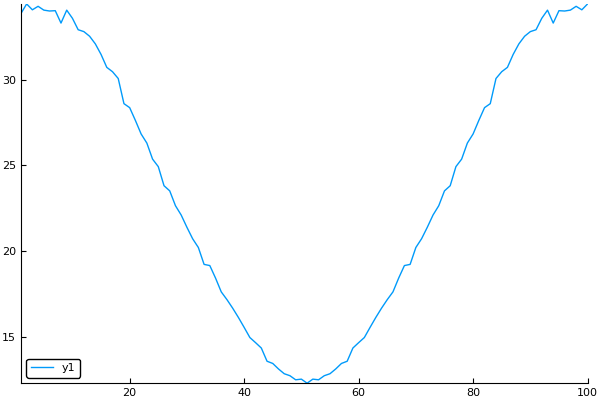

In [37]:
plot(Emat*w)

In [38]:
g = ScalarData(X)
g .= cos.(θ[1:n])+ 0.2*rand(n);

  0.384439 seconds (617.10 k allocations: 22.759 MiB, 2.58% gc time)


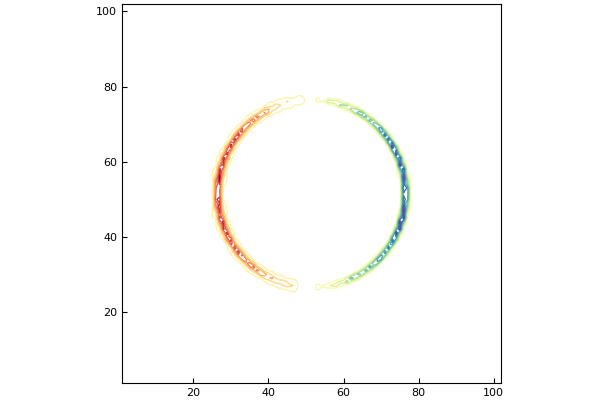

In [39]:
@time plot(Hmat*g)

In [40]:
g2 = ScalarData(X)
@time H(g2,w);

  0.103518 seconds (117.27 k allocations: 29.503 MiB, 12.35% gc time)


In [41]:
Ẽmat = InterpolationMatrix(H̃,w,g);

  0.112106 seconds (160.98 k allocations: 55.852 MiB, 5.22% gc time)


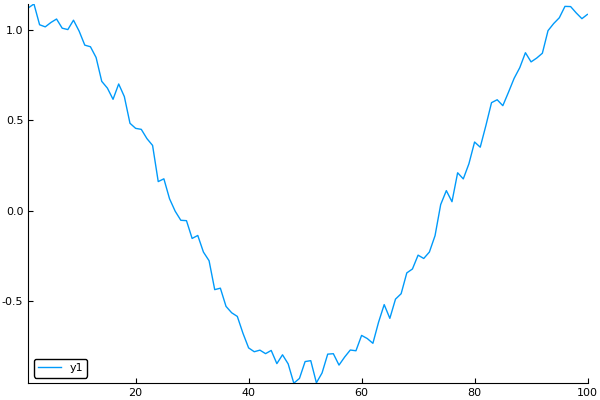

In [42]:
@time H̃(g2,H(w,g));
plot(g2)

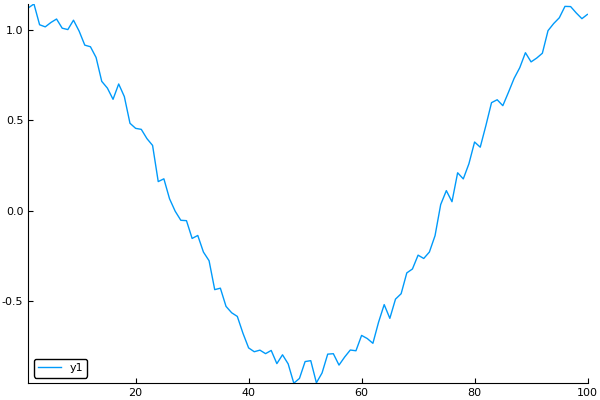

In [43]:
plot(Ẽmat*(Hmat*g))